In [1]:
import re
import numpy as np
from PIL import Image
import cv2 as cv2
import os
import gzip

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
directory = "data/ads/duplicate_ads/"

# Preparing and Augmenting the file

count = 1

for filename in os.listdir(directory):
    filename_without_exten = filename.split('.')[0]
    foldername = "s" + str(count)
    
    new_dir = directory + foldername
    os.mkdir(new_dir)
    
    count = count + 1


from shutil import copyfile

count = 1

for filename in os.listdir(directory):
    foldername = "s" + str(count)
    
    if filename.endswith('.jpg'):
        source = directory + filename.split('.')[0] + '.jpg'
        dest = directory + foldername + "/"
        
        os.rename(source, dest + "1.jpg")
        copyfile(dest + "1.jpg", dest + "2.jpg")
        copyfile(dest + "1.jpg", dest + "3.jpg")
        copyfile(dest + "1.jpg", dest + "4.jpg")
        copyfile(dest + "1.jpg", dest + "5.jpg")
        
        count = count + 1

# Resize images

count = 1
for folder in os.listdir(directory):
    
    if folder.startswith('s'):
        foldername = directory + folder + "/"

        for filename in os.listdir(foldername):
            if filename.endswith('.jpg'):
                imagename = foldername+filename
                img = cv2.imread(imagename, cv2.IMREAD_UNCHANGED)
                dim = (480, 480)
                resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
                cv2.imwrite(foldername + filename, resized)


In [3]:
test_image = "data/ads/duplicate_ads/s2/1.jpg"

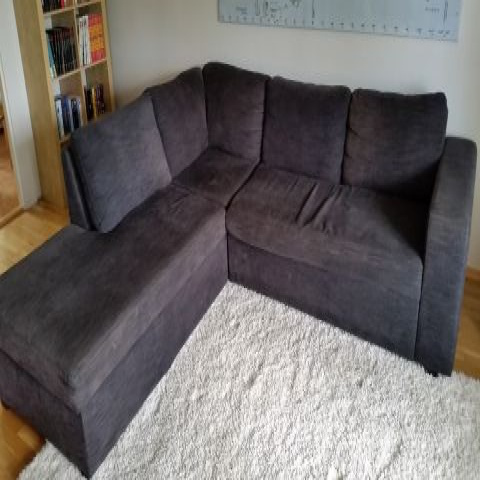

In [4]:
Image.open(test_image)

In [5]:
def read_image(filename):
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    img = cv2.imread(filename)

    return cv2.imdecode(np.frombuffer(buffer, 
                                      dtype='u1' if int(img.max()) < 256 else byteorder+'u2'
                                     ), cv2.IMREAD_GRAYSCALE
                       ).reshape(img.shape[1], img.shape[0])


img = read_image(test_image)
img.shape

(480, 480)

In [6]:
size = 2
total_sample_size = 550
base_url = 'data/ads/duplicate_ads/s'

def get_data(size, total_sample_size):
    #read the image
    image = read_image(base_url + str(1) + '/' + str(1) + '.jpg')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(110):
        for j in range(int(total_sample_size/110)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(5)
                ind2 = np.random.randint(5)
            
            # read the two images
            img1 = read_image(base_url + str(i+1) + '/' + str(ind1 + 1) + '.jpg')
            img2 = read_image(base_url + str(i+1) + '/' + str(ind2 + 1) + '.jpg')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/5)):
        for j in range(5):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(110)
                ind2 = np.random.randint(110)
                if ind1 != ind2:
                    break
                    
            img1 = read_image(base_url + str(ind1+1) + '/' + str(j + 1) + '.jpg')
            img2 = read_image(base_url + str(ind2+1) + '/' + str(j + 1) + '.jpg')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [7]:
X, Y = get_data(size, total_sample_size)

In [8]:
X.shape

(2000, 2, 1, 240, 240)

In [9]:
Y.shape

(2000, 1)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.30)

In [11]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [12]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [13]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/Users/samehamin/anaconda3/envs/image-similarity/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), input_shape=(1, 240, 2..., padding="valid", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()
/Users/samehamin/anaconda3/envs/image-similarity/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), padding="valid", data_format="channels_first")`
/Users/samehamin/anaconda3/envs/image-similarity/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


In [14]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [16]:
epochs = 13
rms = RMSprop()

In [17]:
model = Model(input=[img_a, img_b], output=distance)

/Users/samehamin/anaconda3/envs/image-similarity/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


In [18]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [19]:
model.compile(loss=contrastive_loss, optimizer=rms)

In [20]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [21]:
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=2, nb_epoch=epochs)

/Users/samehamin/anaconda3/envs/image-similarity/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Instructions for updating:
Use tf.cast instead.
Train on 1050 samples, validate on 350 samples
Epoch 1/20
 - 93s - loss: 7.2576 - val_loss: 0.2352
Epoch 2/20
 - 68s - loss: 0.1658 - val_loss: 0.2307
Epoch 3/20
 - 62s - loss: nan - val_loss: nan
Epoch 4/20
 - 60s - loss: nan - val_loss: nan
Epoch 5/20
 - 57s - loss: nan - val_loss: nan
Epoch 6/20
 - 56s - loss: nan - val_loss: nan
Epoch 7/20
 - 56s - loss: nan - val_loss: nan
Epoch 8/20
 - 56s - loss: nan - val_loss: nan
Epoch 9/20
 - 57s - loss: nan - val_loss: nan
Epoch 10/20
 - 56s - loss: nan - val_loss: nan
Epoch 11/20
 - 55s - loss: nan - val_loss: nan
Epoch 12/20
 - 57s - loss: nan - val_loss: nan
Epoch 13/20
 - 54s - loss: nan - val_loss: nan
Epoch 14/20
 - 58s - loss: nan - val_loss: nan
Epoch 15/20
 - 65s - loss: nan - val_loss: nan
Epoch 16/20
 - 64s - loss: nan - val_loss: nan
Epoch 17/20
 - 59s - loss: nan - val_loss: nan
Epoch 18/20
 - 62s - loss: nan - val_loss: nan
Epoch 19/20
 - 64s - loss: nan - val_loss: nan
Epoch 20/

In [ ]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [ ]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

In [ ]:
compute_accuracy(pred, y_test)